## CS445: Computational Photography - Spring 2020

# Programming Final Project: Replacing objects within a Video

### Use Case 


While re-decorating or renovating a house, an interior designer may receive
photos or video of the location/house which could be already fitted with existing items.
Some re-decoration work may require digital removal of existing items from the scene
before new items can be added in place. Items being replaced could be furniture items or
more structural elements in the house such as doors/partition walls etc. Using this
technique, designers could share their ideas to the clients and get feedback on their
remodeling / renovation suggestions.

### Methodology

 - Edge Detection to identify object boundaries
 - Removal of object from all frames
 - Add new objects in scene, using compositing and blending technique
 - Use hole filling technique to fill the gaps

In [2]:
import cv2
import image_helper as img_helper
import numpy as np
import os
import utils

%matplotlib inline
from matplotlib import pyplot as plt

%reload_ext autoreload

In [26]:
input_dir = 'input/'
output_dir = 'output/'


In [27]:
video_file = os.path.join(input_dir, 'Video.MOV')
frames_dir = os.path.join(output_dir, 'frames/')
#utils.video2imageFolder(video_file, frames_dir)


In [28]:
filesinfo = os.scandir(frames_dir)
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
references = {}

ref_im = img_helper.read_image(filenames[0])
ref_im_shape = ref_im.shape

frames = np.zeros((frameCount,ref_im_shape[0],ref_im_shape[1],ref_im_shape[2]), ref_im.dtype)
frames_homography = np.zeros((frameCount, 3, 3))

idx = 0

for img_file in filenames:
    img = img_helper.read_image(img_file)
    frames[idx] = img
    if (idx % 100 == 0 or idx == frameCount-1):
        print('idx:', idx, ' file:', img_file)
        references[idx] = (idx+1 , img)
    idx += 1
                           
print('Completed reading frames')

print(references.keys())

idx: 0  file: output/frames/f0001.jpg
idx: 100  file: output/frames/f0101.jpg
idx: 200  file: output/frames/f0201.jpg
idx: 249  file: output/frames/f0250.jpg
Completed reading frames
dict_keys([0, 100, 200, 249])


In [7]:
def warp_image(im1, im2, canvas):
    im1_H, im1_W, im_C = im1.shape

    ## Example usage of cv2.warpPerspective
    projectedWidth = im1_W*3
    projectedHeight = im1_H*2
    
    projectedHeight, projectedWidth, C = canvas.shape
        
    ref_canvas = img_helper.map_image_to_canvas(im2, canvas)
    
    sourceHomography = homography.auto_homography(im1, ref_canvas, homography.computeHomography, homography.normalizeCoordinates)
    projectedSource = cv2.warpPerspective(im1, sourceHomography, (projectedWidth, projectedHeight))

    return projectedSource, sourceHomography

def create_warped_perspective(images, projections_dir, framesHomography):
    img_cnt = len(images)
    
    assert img_cnt > 0
    
    idx = 0
    prev = None
    blended_frames = []
    
    im_H, im_W, im_C = images[0].shape
     
    canvas_H = im_H * 2
    canvas_W = im_W * 2
    canvas = np.zeros((canvas_H, canvas_W, im_C), dtype=images[0].dtype)
    blendedOutput = canvas.copy()
    

    print('Initializing canvas with reference frame: ', idx)
    canvas = np.zeros((canvas_H, canvas_W, im_C), dtype=images[0].dtype)
    
    idx = 0
    reference_im, ref_homography = warp_image(images[125], images[125], canvas)
    reference_im_before_2, src_homography = warp_image(images[90], images[125], canvas)
    reference_im_before_1, src_homography = warp_image(images[60], reference_im_before_2, canvas)
    reference_im_before_0, src_homography = warp_image(images[30], reference_im_before_1, canvas)
    reference_im_after_0, src_homography = warp_image(images[160], images[125], canvas)
    reference_im_after_1, src_homography = warp_image(images[190], reference_im_after_0, canvas)
    reference_im_after_2, src_homography = warp_image(images[220], reference_im_after_1, canvas)
    
    utils.display_images(7, [reference_im_before_0, reference_im_before_1, reference_im_before_2, \
                             reference_im, reference_im_after_0, reference_im_after_1, reference_im_after_2])

    for idx in range(img_cnt):
        
        img = images[idx]
        reference = None
        
        if (idx <30):
            reference = reference_im_before_0
        elif (idx <60):
            reference = reference_im_before_1
        elif (idx <90):
            reference = reference_im_before_2
        elif (idx <125):
            reference = reference_im
        elif (idx > 160):
            reference = reference_im_after_0
        elif (idx > 190):
            reference = reference_im_after_1
        else:
            reference = reference_im_after_2
            
        projectedSrc, srcHomography = warp_image(img, reference, canvas)
        framesHomography[idx] = srcHomography
        
        img_path = os.path.join(projections_dir, 'f{:04d}.jpg'.format(idx+1))
        img_helper.write_image(img_path, projectedSrc.astype('double'), np.float32)
    
    
    return 



Initializing canvas with reference frame:  0


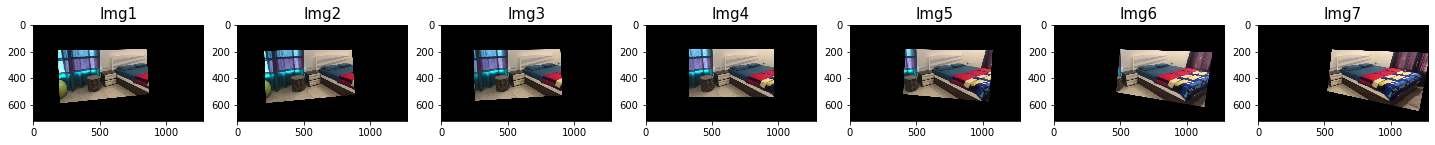

In [8]:
projections_dir = os.path.join(output_dir, 'projections/')

create_warped_perspective(frames, projections_dir, frames_homography)



In [11]:
np.save(os.path.join(output_dir, 'homographies.txt'), frames_homography)

In [12]:
video_path = os.path.join(output_dir, 'ProjectionVideo.mpeg')

utils.imageFolder2mpeg(projections_dir, video_path )

## Create panorama using the projected frames

In [22]:
import cv2
import filters
import homography
import image_helper as img_helper
import numpy as np
import os
import texture_lib
import utils

from datetime import datetime
from numpy.linalg import svd, inv
from skimage import draw
%matplotlib inline
from matplotlib import pyplot as plt

%reload_ext autoreload


In [4]:
input_dir = 'input/'
output_dir = 'output/'


In [23]:
projections_dir = os.path.join(output_dir, 'projections/')


In [13]:
filesinfo = os.scandir(projections_dir)
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

fileCount = len(filenames)

ref_img = img_helper.read_image(filenames[0])
ref_img_shape = ref_img.shape

projections = np.zeros((fileCount,ref_img_shape[0],ref_img_shape[1],ref_img_shape[2]), ref_img.dtype)

idx = 0

for img_file in filenames:
    img = img_helper.read_image(img_file)
    projections[idx] = img
    if (idx % 100 == 0 or idx == fileCount-1):
        print('Reading projection idx:', idx, ' file:', img_file)
    idx += 1
                        
panorama_im = np.zeros(ref_img.shape, ref_img.dtype)


Reading projection idx: 0  file: output/projections/f0001.jpg
Reading projection idx: 100  file: output/projections/f0101.jpg
Reading projection idx: 200  file: output/projections/f0201.jpg
Reading projection idx: 249  file: output/projections/f0250.jpg


In [14]:

progress = 0

start_time = datetime.now()

print(datetime.now(), ' Generating background image')
last = False
pixel_cnt = 0

frames_T = np.transpose(projections)
H,W,C = projections[0].shape

for y in range(H):
    for x in range(W):
        for c in range(C):
            if (np.sum(frames_T[c][x][y]) > 0):
                
                extracted = np.extract(frames_T[c][x][y] > 0, frames_T[c][x][y])
                median_value = np.median(extracted).astype(np.uint8)
            
                panorama_im[y][x][c] = median_value
            
    
    percent = y/H*100
    if((percent > 1 and percent % 5 == 0) or y == H-1):
        elapsed = datetime.now() - start_time
        print(str(datetime.now()) + ' Progress :', '{:.0f}%'.format(percent) + ' Elapse time: ' + str(elapsed))

elapsed = datetime.now() - start_time
print(str(datetime.now()),' Completed background image. Elapse time: ' + str(elapsed))


2020-05-08 15:50:22.568159  Generating background image
2020-05-08 15:50:23.951834 Progress : 5% Elapse time: 0:00:01.383709
2020-05-08 15:50:25.303243 Progress : 10% Elapse time: 0:00:02.735116
2020-05-08 15:50:26.640634 Progress : 15% Elapse time: 0:00:04.072508
2020-05-08 15:50:27.984373 Progress : 20% Elapse time: 0:00:05.416247
2020-05-08 15:50:30.328224 Progress : 25% Elapse time: 0:00:07.760099
2020-05-08 15:50:38.217596 Progress : 30% Elapse time: 0:00:15.649470
2020-05-08 15:50:46.970021 Progress : 35% Elapse time: 0:00:24.401895
2020-05-08 15:50:56.217014 Progress : 40% Elapse time: 0:00:33.648888
2020-05-08 15:51:05.472030 Progress : 45% Elapse time: 0:00:42.903904
2020-05-08 15:51:13.084321 Progress : 50% Elapse time: 0:00:50.516196
2020-05-08 15:51:28.632020 Progress : 60% Elapse time: 0:01:06.063895
2020-05-08 15:51:36.322936 Progress : 65% Elapse time: 0:01:13.754811
2020-05-08 15:51:45.082880 Progress : 70% Elapse time: 0:01:22.514756
2020-05-08 15:51:53.181651 Progress

True

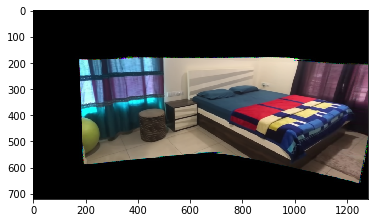

In [15]:
plt.imshow(panorama_im)

img_helper.write_image(os.path.join(output_dir,'panorama.jpg'), panorama_im)


## Segmentation using cv2.GrabCut

In [1]:
import cv2
import filters
import homography
import image_helper as img_helper
import numpy as np
import os
import texture_lib
import utils

from datetime import datetime
from numpy.linalg import svd, inv
from skimage import draw
%matplotlib inline
from matplotlib import pyplot as plt

%reload_ext autoreload

In [5]:
input_dir = 'input/'
output_dir = 'output/'


In [43]:

import importlib
import utils
importlib.reload(utils)


<module 'utils' from '/Users/deeptisharma/Documents/Personal/MCS-UIUC/2020-01-05-Spring/I-CS4445_ComputationalPhotography/FinalProject/code_new/utils.py'>

(720, 1280, 3)


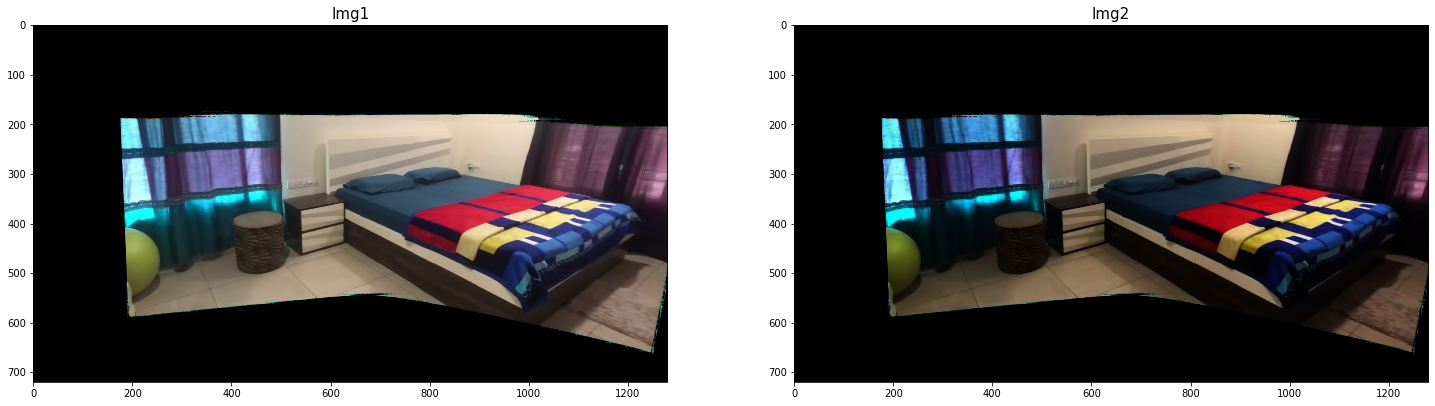

In [46]:
import matplotlib.pyplot as plt
%matplotlib notebook

%matplotlib inline
im = img_helper.read_image(os.path.join(output_dir,'panorama.jpg'))

print(im.shape)


im_enh = utils.gamma_correction(im, 1.7)

utils.display_images(2, [im, im_enh])

In [50]:
%matplotlib inline

### Segment Headboard

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


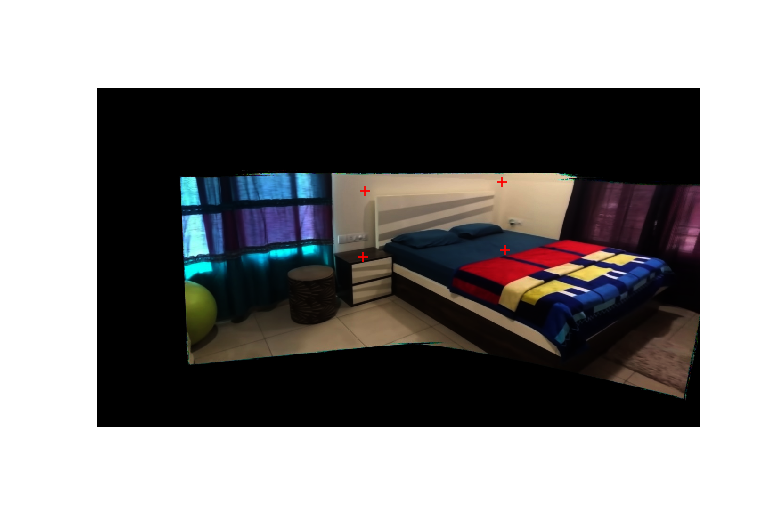

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook

im_coords = utils.specify_keypoints(im_enh)


(568, 217, 285, 110)


True

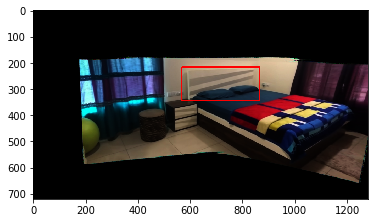

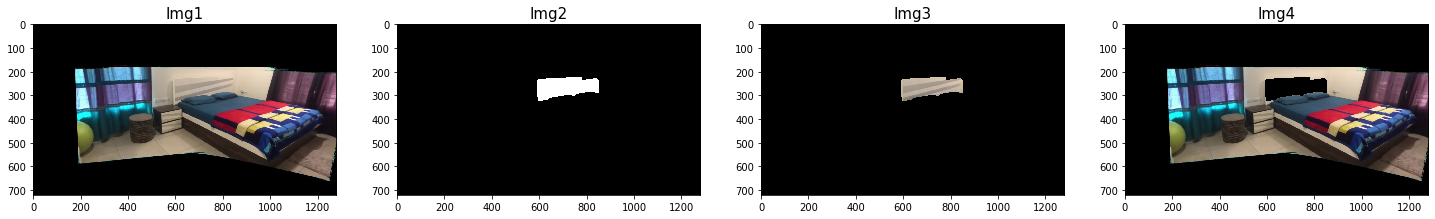

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

start_point = (im_coords[0][0].astype(int), im_coords[1][0].astype(int))
end_point = (im_coords[0][2].astype(int), im_coords[1][2].astype(int))
im_rectangle = cv2.rectangle(im_enh.copy(),start_point,end_point,(255,0,0),3)
plt.imshow(im_rectangle)


rectangle = (start_point[0],start_point[1], 285, 110)

print(rectangle)

mask = np.zeros(im.shape[:2],im.dtype)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

mask, bgdModel, fgdModel = cv2.grabCut(im_enh.copy(), mask, rectangle,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
object_mask = np.where((mask==2)|(mask==0),0.0,1.0).astype(np.uint8)

object_im = im*object_mask[:,:,np.newaxis]

utils.display_images(4, [im, object_mask, object_im, im - object_im ])

img_helper.write_image(os.path.join(output_dir, 'headboard.jpg'), object_im)

### Segment Side table

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


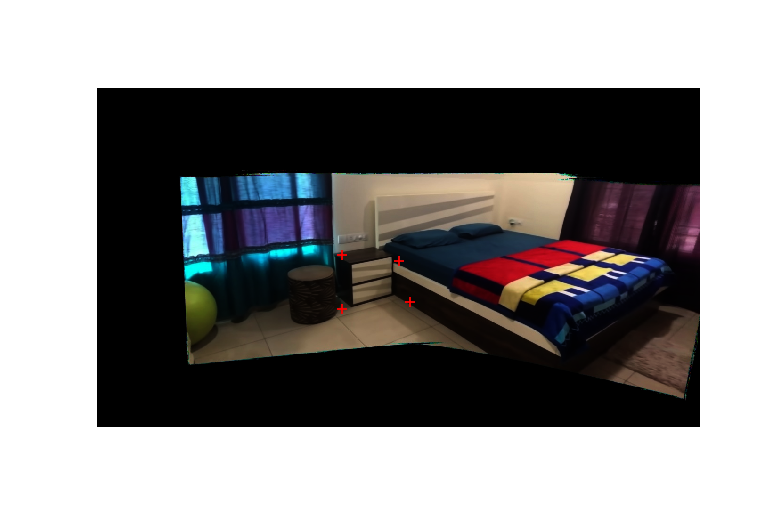

In [56]:
import matplotlib.pyplot as plt
%matplotlib notebook

im_coords = utils.specify_keypoints(im_enh)


(518, 354, 120, 100)


True

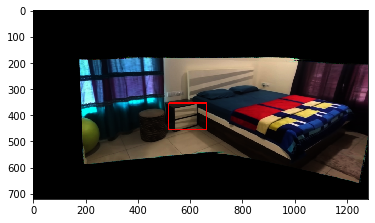

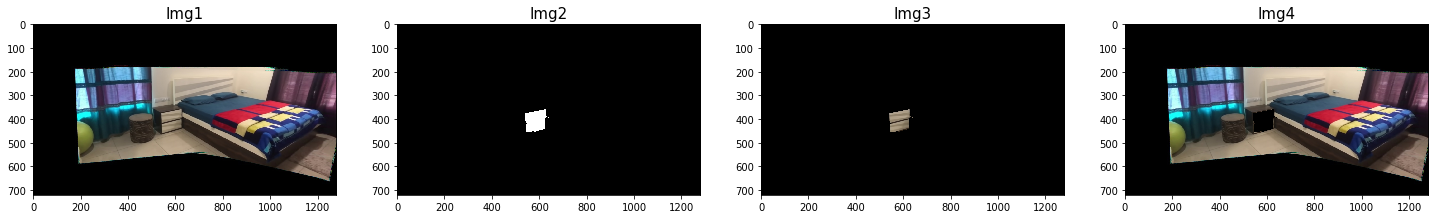

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

start_point = (im_coords[0][0].astype(int), im_coords[1][0].astype(int))
end_point = (im_coords[0][2].astype(int), im_coords[1][2].astype(int))
im_rectangle = cv2.rectangle(im_enh.copy(),start_point,end_point,(255,0,0),3)
plt.imshow(im_rectangle)


rectangle = (start_point[0],start_point[1], 120, 100)

print(rectangle)

mask = np.zeros(im.shape[:2],im.dtype)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

mask, bgdModel, fgdModel = cv2.grabCut(im_enh.copy(), mask, rectangle,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
object_mask = np.where((mask==2)|(mask==0),0.0,1.0).astype(np.uint8)

object_im = im*object_mask[:,:,np.newaxis]

utils.display_images(4, [im, object_mask, object_im, im - object_im ])

img_helper.write_image(os.path.join(output_dir, 'sidetable.jpg'), object_im)

### Segment bedside panel

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


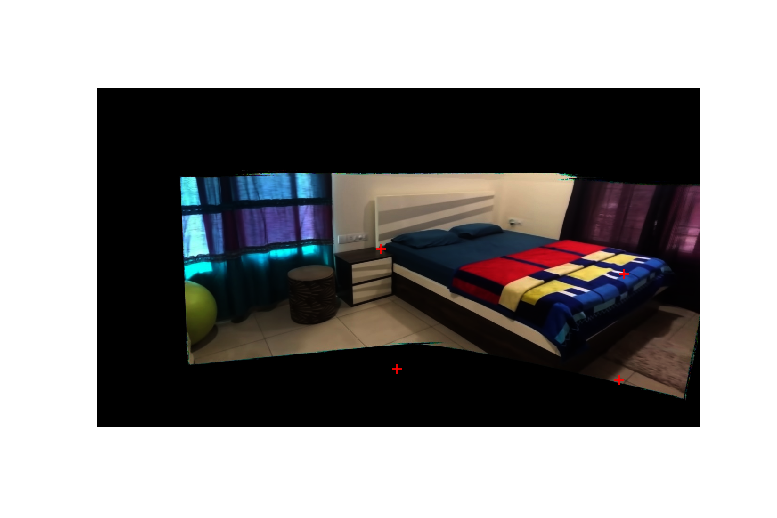

In [70]:
import matplotlib.pyplot as plt
%matplotlib notebook

im_coords = utils.specify_keypoints(im_enh)


(602, 340, 400, 300)


True

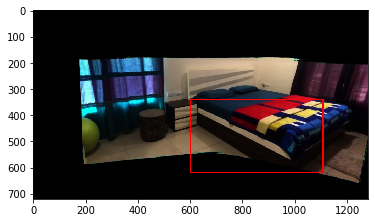

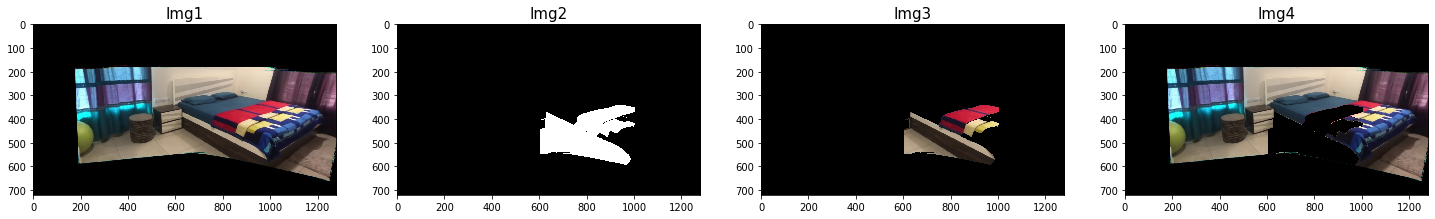

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

start_point = (im_coords[0][0].astype(int), im_coords[1][0].astype(int))
end_point = (im_coords[0][2].astype(int), im_coords[1][2].astype(int))
im_rectangle = cv2.rectangle(im_enh.copy(),start_point,end_point,(255,0,0),3)
plt.imshow(im_rectangle)


rectangle = (start_point[0],start_point[1], 400, 300)

print(rectangle)

mask = np.zeros(im.shape[:2],im.dtype)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

mask, bgdModel, fgdModel = cv2.grabCut(im_enh.copy(), mask, rectangle,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
object_mask = np.where((mask==2)|(mask==0),0.0,1.0).astype(np.uint8)

object_im = im*object_mask[:,:,np.newaxis]

utils.display_images(4, [im, object_mask, object_im, im - object_im ])

img_helper.write_image(os.path.join(output_dir, 'panel.jpg'), object_im)

### All segmented objects

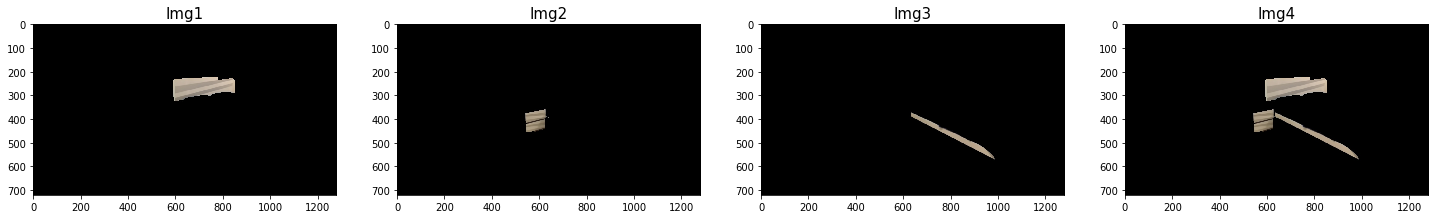

In [145]:

panorama = img_helper.read_image(os.path.join(output_dir, 'panorama.jpg'))
headboard = img_helper.read_image(os.path.join(output_dir, 'headboard.jpg'))
sidetable = img_helper.read_image(os.path.join(output_dir, 'sidetable.jpg'))
panel = img_helper.read_image(os.path.join(output_dir, 'panel.jpg'))

segments = headboard + sidetable + panel

mask = np.where(segments == 0, 0.0, 1.0)
segments_removed = panorama * ( 1 - mask).astype(np.uint8)
segments_only = panorama * mask


utils.display_images(4, [headboard, sidetable, panel, segments])


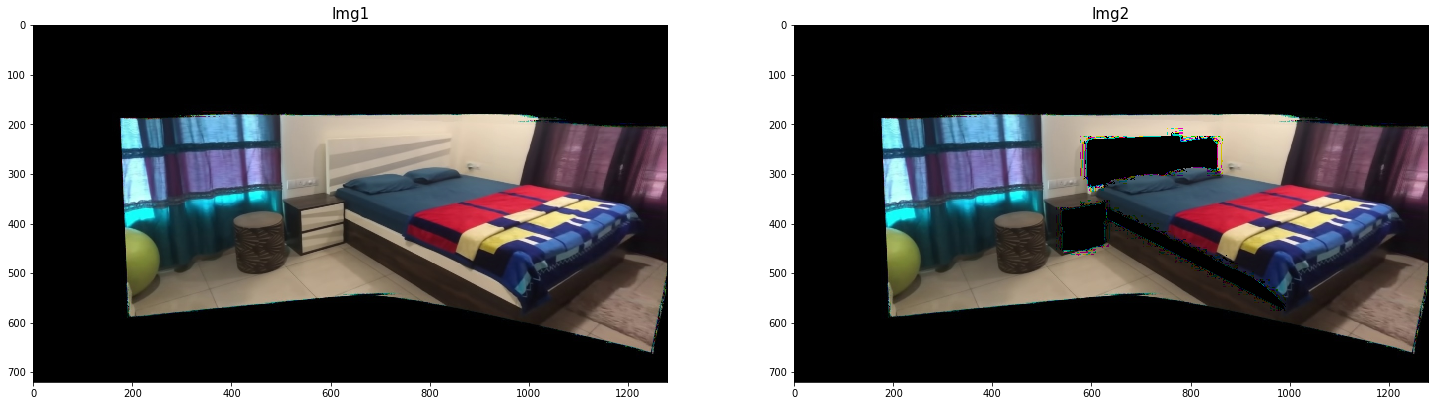

In [146]:
utils.display_images(2, [ panorama, segments_removed])

In [147]:

img_helper.write_image(os.path.join(output_dir, 'generated_segments.png'), segments)


True

### Updating segmented objects with replacements

In [10]:

import cv2
import filters
import homography
import image_helper as img_helper
import numpy as np
import os
import texture_lib
import utils

from datetime import datetime
from numpy.linalg import svd, inv
from skimage import draw
%matplotlib inline
from matplotlib import pyplot as plt

%reload_ext autoreload

In [11]:
input_dir = 'input/'
output_dir = 'output/'

panorama = img_helper.read_image(os.path.join(output_dir, 'panorama.jpg'))

### Add new texture to the identified segments 

(720, 1280, 3)


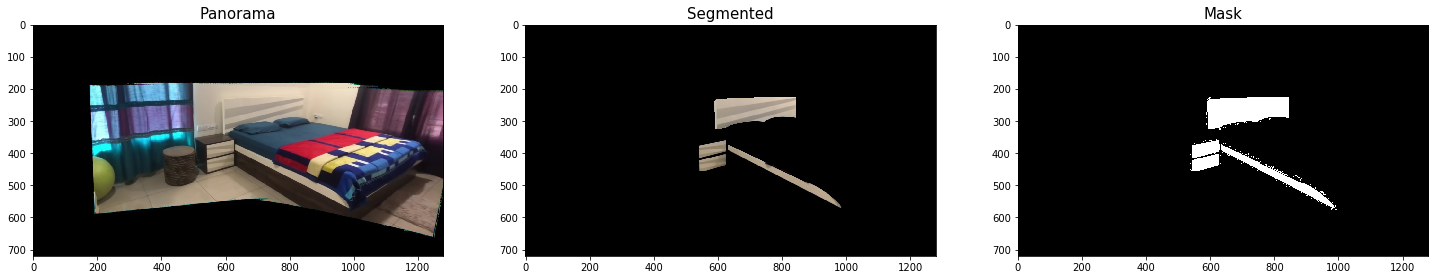

In [12]:
segments =  img_helper.read_image(os.path.join(output_dir, 'segments.png'))

segment_mask = np.where(segments == 0, 0, 1).astype(np.uint8)
segment_mask_T = segment_mask.transpose()
segment_mask_T[0] = segment_mask_T[0]*segment_mask_T[1]*segment_mask_T[2]
segment_mask_T[1] = segment_mask_T[0]
segment_mask_T[2] = segment_mask_T[0]

segment_mask = segment_mask_T.transpose()

print(panorama.shape)
utils.display_images(3, [panorama, segments, segment_mask*255], ['Panorama', 'Segmented', 'Mask'])


In [13]:
part1 =  img_helper.read_image(os.path.join(output_dir, 'part1.png'))
part2 =  img_helper.read_image(os.path.join(output_dir, 'part2.png'))
part3 =  img_helper.read_image(os.path.join(output_dir, 'part3.png'))
part4 =  img_helper.read_image(os.path.join(output_dir, 'part4.png'))

#total = part1 + part2 + part3 + part4 

H,W,C = part1.shape
new_image = np.zeros(part1.shape, part1.dtype)
for y in range(H):
    for x in range(W):
        for c in range(C):
            new_image[y,x,c] = min(part1[y,x,c],part2[y,x,c],part3[y,x,c],part4[y,x,c])
                
                


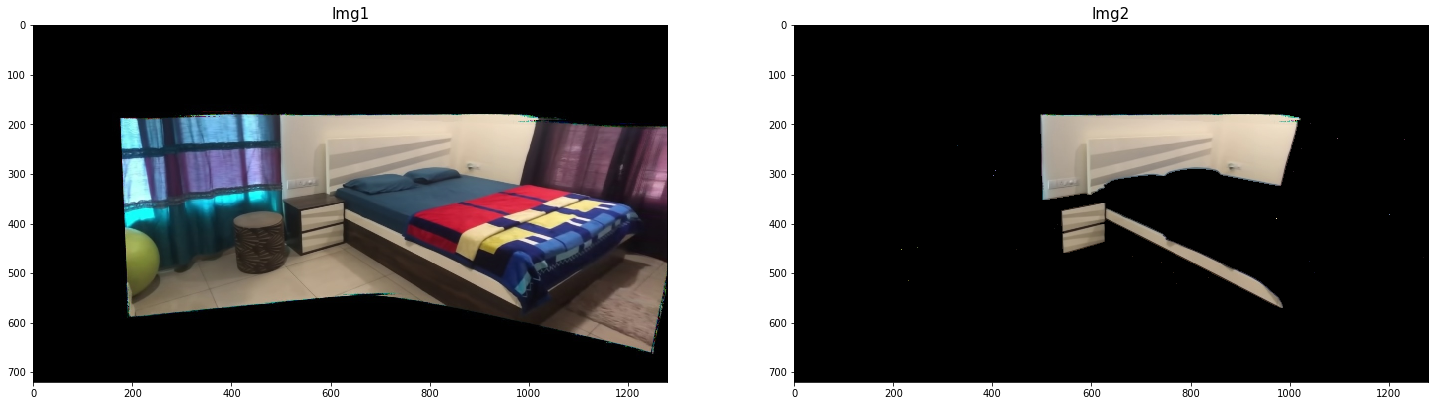

In [14]:
panorama_gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
new_image_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

panorama_blur = filters.apply_gaussian_filter(panorama, 5, 5)
new_image_blur = filters.apply_gaussian_filter(new_image, 5, 5)

mask = np.where(abs(panorama_blur - new_image_blur) < 5, 0, 1)
new_mask = mask.copy()
for y in range(H):
    for x in range(W):
        min_val = min(new_mask[y,x])
        new_mask[y,x] = [min_val, min_val, min_val]
        
utils.display_images(2, [panorama ,panorama*new_mask])


In [15]:
segment_mask = new_mask.copy()

In [16]:
import importlib
import texture_lib
importlib.reload(texture_lib)
%matplotlib inline

def update_texture(texture_im, trgt_im, mask3d, out_file='output/texture_created.jpg'):
    
    new_texture = texture_lib.resize_image(texture_im, trgt_im)
    img_helper.write_image(out_file, new_texture)
    
    print(new_texture.shape)
    object_new = new_texture * mask3d
    img_new = trgt_im * ( 1 - mask3d) + object_new

    utils.display_images(3, [trgt_im, object_new, img_new ])
    
    return img_new


sample shape:  (600, 800, 3)
target shape:  (720, 1280, 3)
(720, 1280, 3)


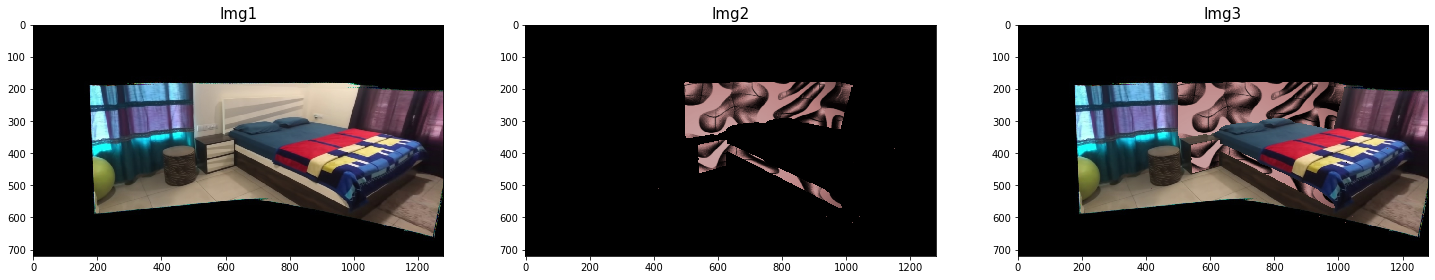

In [24]:
replace_img_path =  os.path.join(input_dir, 'red_texture.png')
panorama_path = os.path.join(output_dir, 'panorama.jpg')

new_texture = img_helper.read_image(replace_img_path)
panorama = img_helper.read_image(panorama_path)

new_img = update_texture(new_texture, panorama, segment_mask)

object_img = panorama * segment_mask


True

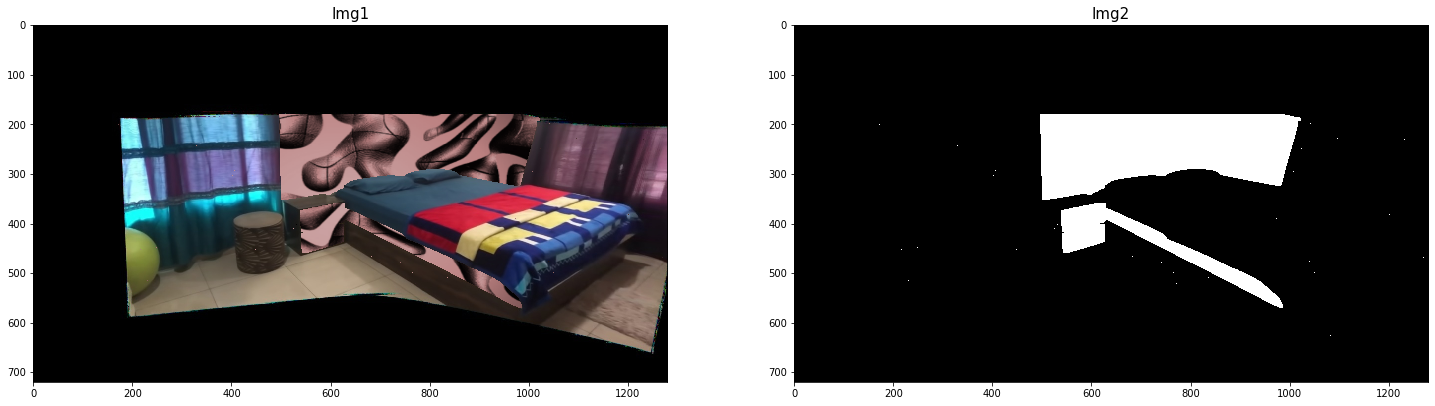

In [25]:
output_img_path = os.path.join(output_dir, 'panorama_updated4.jpg')
mask_img_path = os.path.join(output_dir, 'panorama_mask.jpg')

mask_im = segment_mask.astype(np.float32)

utils.display_images(2, [new_img, mask_im ])

img_helper.write_image(output_img_path, new_img)
img_helper.write_image(mask_img_path, mask_im, np.float32)


### Generate New Set of Images for video


In [1]:
original_frames_dir = 'output/frames'
projections_dir = 'output/projections'


bg_img_path = os.path.join(output_dir, 'panorama_updated4.jpg')
bg_img = img_helper.read_image(bg_img_path)

plt.imshow(bg_img)

NameError: name 'os' is not defined

In [30]:
def read_frames(input_path):
    
    filesinfo = os.scandir(input_path)
    filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
    filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    frameCount = len(filenames)
    frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
    frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.uint8)

    for idx, file_i in enumerate(filenames):
        frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB)

    return frames

In [31]:
frames = read_frames(original_frames_dir)
projected_frames = read_frames(projections_dir)


In [32]:
assert len(frames) == len(projected_frames)

print(len(frames))

250


In [33]:
'''
# Reload previously generated Homogprahies


frameCount = len(projected_frames)
reference_im = projected_frames[125].copy()
projection_homography = np.zeros((frameCount,3,3))

for idx in range(frameCount):
    frames_homography[idx] = homography.auto_homography(frames[idx],\
                                   reference_im, \
                                   homography.computeHomography, \
                                   homography.normalizeCoordinates)

    if (idx % 50 == 0):
        print('Homography done so far: ', str(idx+1))
    
print('Done')
'''

homography_file = os.path.join(output_dir, 'homographies.txt.npy')
             
frames_homography = np.load(homography_file)
frameCount = len(frames_homography)

print(frameCount)

250


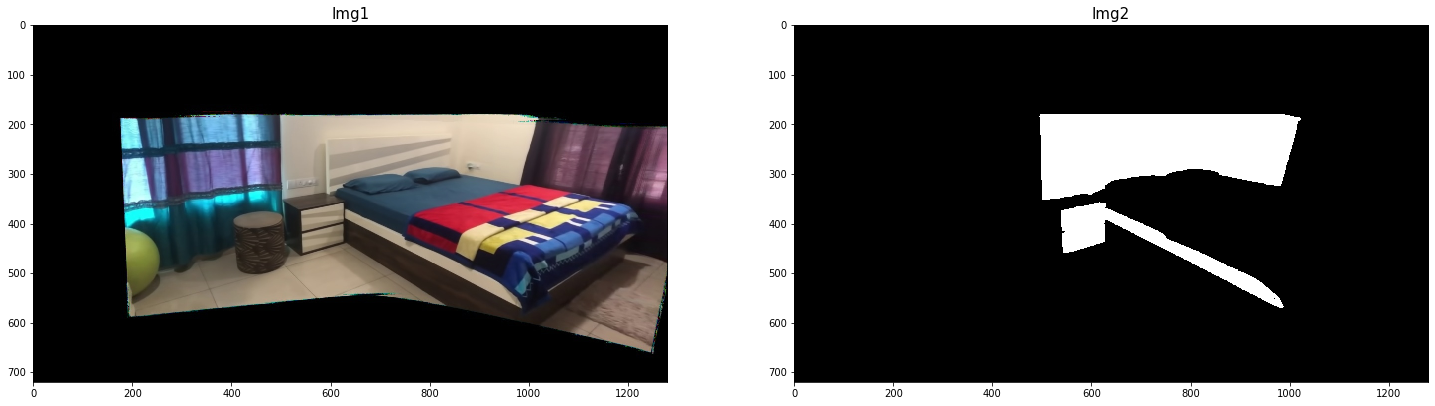

In [34]:
panorama = img_helper.read_image(os.path.join(output_dir, 'panorama.jpg'))
panorama_updated1 = img_helper.read_image(os.path.join(output_dir, 'panorama_updated3.jpg'))
panorama_updated2 = img_helper.read_image(os.path.join(output_dir, 'panorama_updated2.jpg'))
panorama_mask = img_helper.read_image(os.path.join(output_dir, 'panorama_mask.jpg'))
panorama_mask = np.where(panorama_mask == 0, 0, 1)


utils.display_images(2, [panorama, panorama_mask*255])

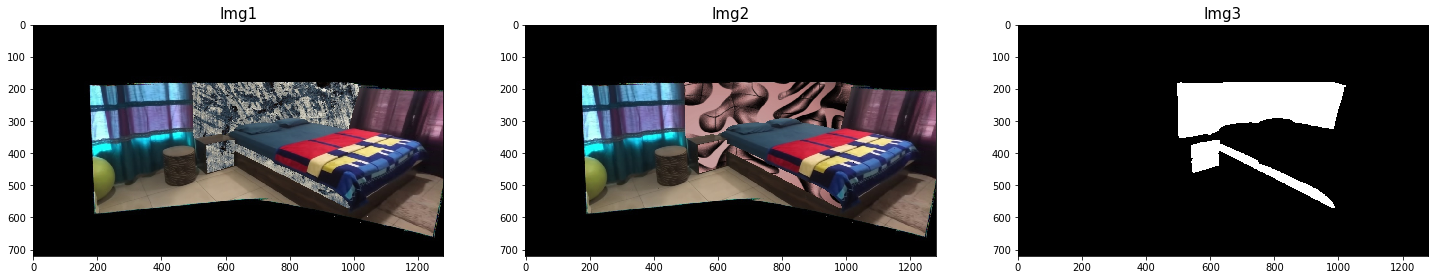

In [40]:
frame_H, frame_W, frame_C = frames[0].shape

new_frames_dir = os.path.join(output_dir, 'frames_edited/')
segmented_mask3d = panorama_mask.copy()
textured1 = panorama_updated1.copy() 
textured2 = panorama_updated2.copy() 

utils.display_images(3, [textured1, textured2, segmented_mask3d*255] )

### Add new texture

In [41]:
for idx in range(frameCount):
    
    new_frame_idx = frameCount - idx - 1
    
    original_frame = frames[new_frame_idx]
    H = frames_homography[new_frame_idx]
    H_inv = inv(H)

    recovered_frame = cv2.warpPerspective(panorama, H_inv, (frame_W, frame_H))
    updated_frame = cv2.warpPerspective(textured1, H_inv, (frame_W, frame_H))
   
    original_filtered = filters.apply_gaussian_filter(original_frame, 5, 3 )
    recovered_filtered = filters.apply_gaussian_filter(recovered_frame, 5, 3)
    updated_filtered = filters.apply_gaussian_filter( updated_frame, 5, 3)
    
    mask = np.where(abs(recovered_filtered - updated_filtered) > 1 , 1.0, 0.0).astype(np.float32)
    mask2 = np.where(abs(recovered_filtered - original_filtered) > 1 , 0.0, 1.0).astype(np.float32)
    mask3 = np.where(mask==mask2, 0.0, 1.0).astype(np.float32)
    
    mask_T = mask.transpose()
    mask_T[0] = mask_T[0] * mask_T[1] * mask_T[2]
    mask_T[1] = mask_T[0]
    mask_T[2] = mask_T[0]
    new_mask = mask_T.transpose()
    
    if (idx < 30):
        new_frame = (original_frame*new_mask).astype(np.uint8)
    else:
        if(idx < 60):
            new_frame = (updated_frame*new_mask).astype(np.uint8)
        else:
            new_frame = original_frame * ( 1 - mask) + updated_frame * mask
        
    new_frame_path = os.path.join(new_frames_dir,'f{:04d}.jpg'.format(frameCount + idx+1))
    
    #utils.display_images(2, [original_frame, new_frame], ['Original', 'Updated'])
    img_helper.write_image(new_frame_path, new_frame)
   

###  Add another texture

In [42]:
for idx in range(frameCount):
    
    new_frame_idx = idx
    
    original_frame = frames[new_frame_idx]
    H = frames_homography[new_frame_idx]
    H_inv = inv(H)

    recovered_frame = cv2.warpPerspective(panorama, H_inv, (frame_W, frame_H))
    updated_frame = cv2.warpPerspective(textured2, H_inv, (frame_W, frame_H))
   
    original_filtered = filters.apply_gaussian_filter(original_frame, 5, 3 )
    recovered_filtered = filters.apply_gaussian_filter(recovered_frame, 5, 3)
    updated_filtered = filters.apply_gaussian_filter( updated_frame, 5, 3)
    
    mask = np.where(abs(recovered_filtered - updated_filtered) > 1 , 1.0, 0.0).astype(np.float32)
    mask2 = np.where(abs(recovered_filtered - original_filtered) > 1 , 0.0, 1.0).astype(np.float32)
    mask3 = np.where(mask==mask2, 0.0, 1.0).astype(np.float32)
    
    mask_T = mask.transpose()
    mask_T[0] = mask_T[0] * mask_T[1] * mask_T[2]
    mask_T[1] = mask_T[0]
    mask_T[2] = mask_T[0]
    new_mask = mask_T.transpose()
    
    if (idx < 30):
        new_frame = (original_frame*new_mask).astype(np.uint8)
    else:
        if(idx < 60):
            new_frame = (updated_frame*new_mask).astype(np.uint8)
        else:
            new_frame = original_frame * ( 1 - mask) + updated_frame * mask
        
    new_frame_path = os.path.join(new_frames_dir,'f{:04d}.jpg'.format(2 * frameCount + idx+1))
    #print(new_frame_path)
    
    #utils.display_images(2, [original_frame, new_frame], ['Original', 'Updated'])
    img_helper.write_image(new_frame_path, new_frame)
   

In [43]:
import shutil

def copy_files(src_dir, dst_dir):
    filesinfo = os.scandir(src_dir)
    filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]

    if(not os.path.exists(dst_dir)):
        print('Destination directory does not exist. Please create')
        return None
    
    for file in filenames:
        shutil.copy(file, dst_dir)
        
merged_frames_dir = os.path.join(output_dir, 'frames_merged/')


copy_files(original_frames_dir, merged_frames_dir)
copy_files(new_frames_dir, merged_frames_dir)


In [44]:
final_video_path = os.path.join(output_dir, 'FinalVideo.mpeg')

utils.imageFolder2mpeg(merged_frames_dir, final_video_path )

### Add cat and blend it with the frames

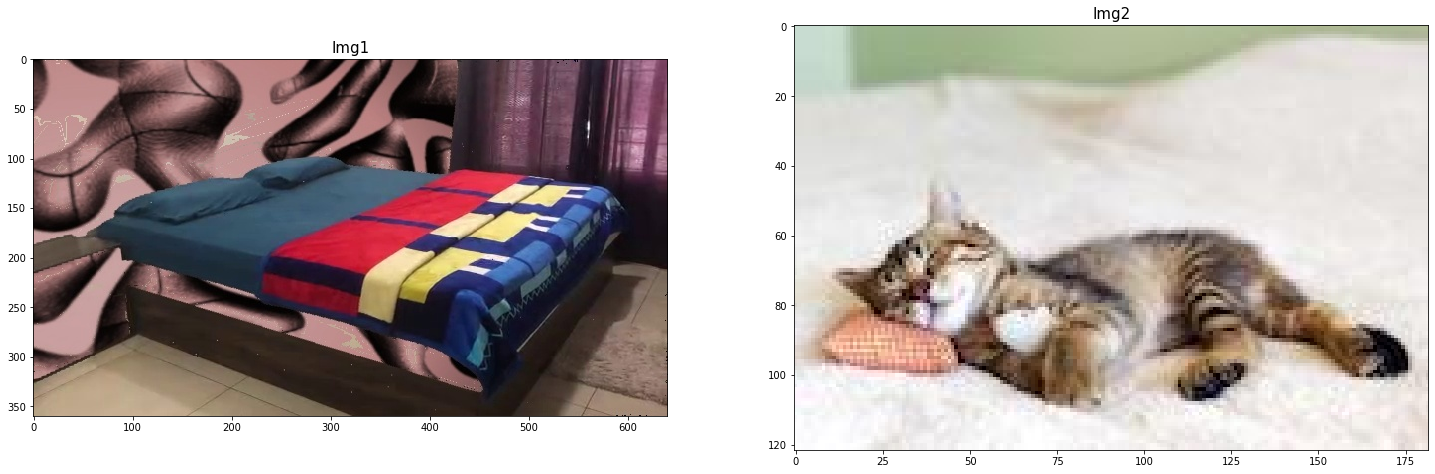

In [149]:
cat_img = img_helper.read_image(os.path.join(input_dir, 'cat_sleeping.jpg'))
#cat_img = filters.apply_gaussian_filter(cat, 5, 3)

ref_frame = img_helper.read_image(os.path.join(merged_frames_dir, 'f0750.jpg'))

utils.display_images(2, [ref_frame, cat_img])

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


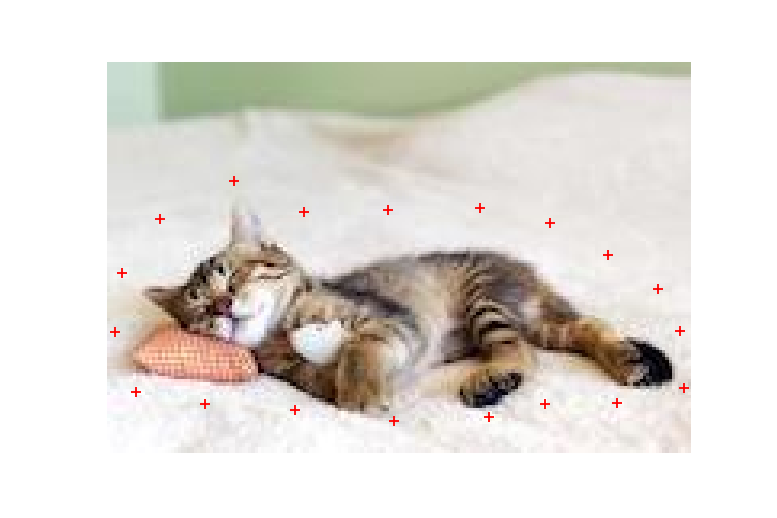

In [151]:
import matplotlib.pyplot as plt
%matplotlib notebook

im_coords = utils.specify_keypoints(cat_img)


<Figure size 432x288 with 0 Axes>

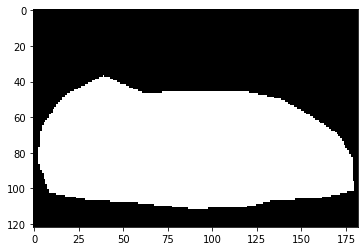

In [152]:
import matplotlib.pyplot as plt
%matplotlib inline


xs = im_coords[0]
ys = im_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = img_helper.get_mask(ys, xs, cat)


If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


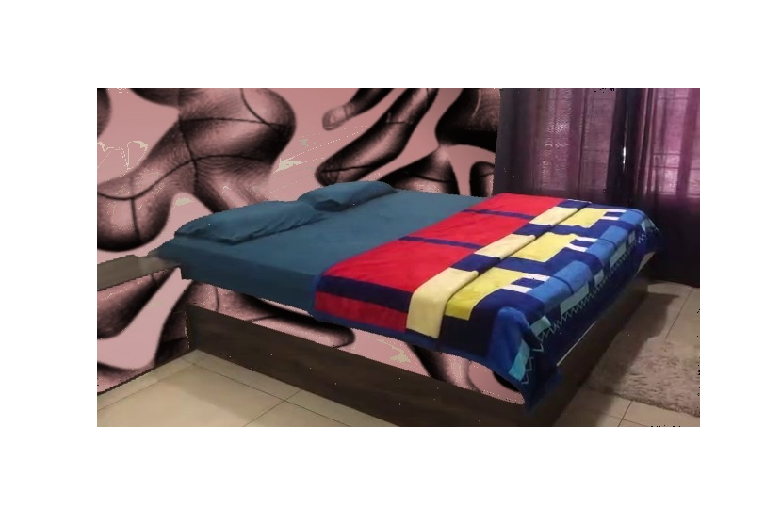

In [154]:
%matplotlib notebook
import matplotlib.pyplot as plt


bottom_center = img_helper.specify_bottom_center(ref_frame)

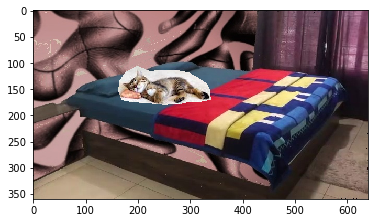

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt

obj_img = cat/255.0
bg_img = ref_frame/255.0

cropped_object, obj_mask = img_helper.align_source(obj_img, mask, bg_img, bottom_center)

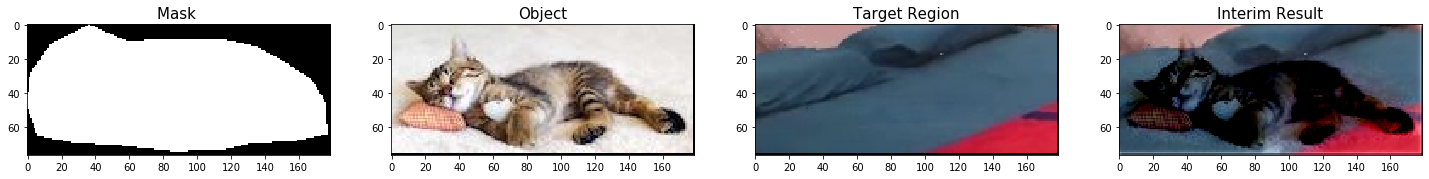

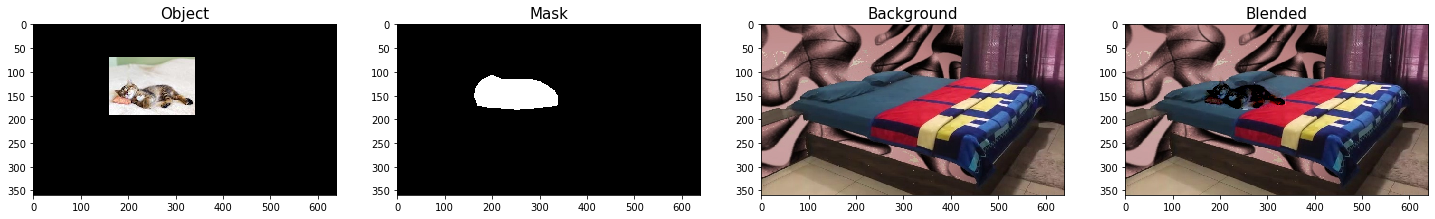

In [156]:
import importlib
import blending
importlib.reload(blending)
%matplotlib inline

im_rgb, im_bgr = blending.mix_blend(cropped_object, obj_mask, bg_img)

In [191]:
new_frame = (im_rgb* 255).astype(np.uint8)

obj_mask_3d = np.zeros(new_frame.shape, new_frame.dtype)

obj_mask_T = np.transpose(obj_mask)
obj_mask_3d_T = obj_mask_3d.transpose()
obj_mask_3d_T[0] = obj_mask_T
obj_mask_3d_T[1] = obj_mask_T
obj_mask_3d_T[2] = obj_mask_T
obj_mask_3d = obj_mask_3d_T.transpose()

count = 3 * frameCount + 1

cropped_cat_img = ( (bg_img*(1-obj_mask_3d) + cropped_object * obj_mask_3d) * 255).astype(np.uint8)


for idx in range(150):
    new_frame_path = os.path.join(new_frames_dir,'f{:04d}.jpg'.format(3*frameCount + idx + 1))
    
    
    if (idx < 60):
        img = cropped_cat_img 
    else:
        img = new_frame
       
    #plt.figure()
    #plt.imshow(img)

    img_helper.write_image(new_frame_path, img)

        

In [192]:
import shutil

def copy_files(src_dir, dst_dir):
    filesinfo = os.scandir(src_dir)
    filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]

    if(not os.path.exists(dst_dir)):
        print('Destination directory does not exist. Please create')
        return None
    
    for file in filenames:
        shutil.copy(file, dst_dir)
        
merged_frames_dir = os.path.join(output_dir, 'frames_merged/')

copy_files(new_frames_dir, merged_frames_dir)


In [193]:
final_video_path = os.path.join(output_dir, 'FinalVideoWithCat.mpeg')

utils.imageFolder2mpeg(merged_frames_dir, final_video_path )